In [1]:
import pandas as pd
data = pd.read_csv('exchange_rate.csv')

In [2]:
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

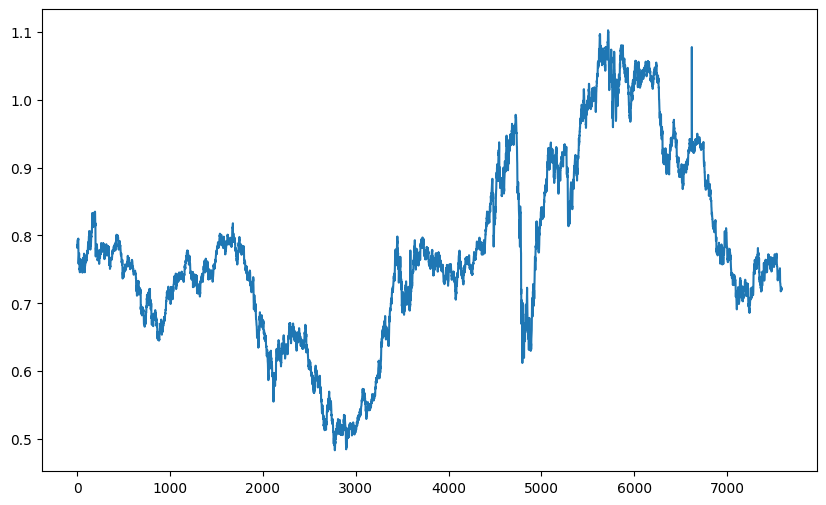

In [4]:
plt.figure(figsize=(10,6))
data.Ex_rate.plot()

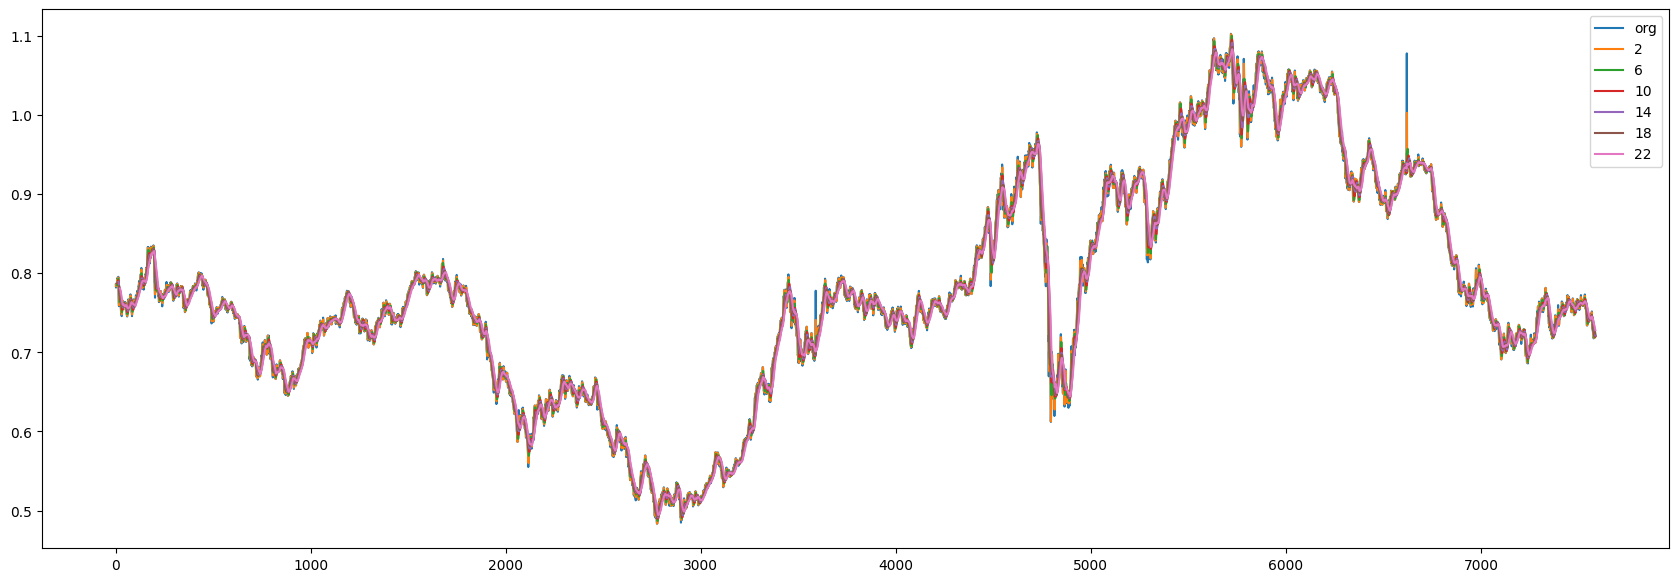

In [9]:
plt.figure(figsize=(21,7))
data.Ex_rate.plot(label="org")
for i in range(2,24,4):
    data["Ex_rate"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')    

In [11]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #SES
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

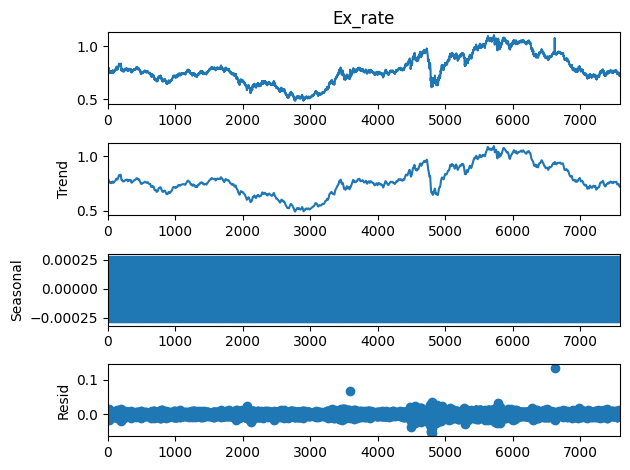

In [12]:
decompose_ts_add  =seasonal_decompose(data.Ex_rate, period=12)
decompose_ts_add.plot()
plt.show()

### Part 2: Model Building - ARIMA

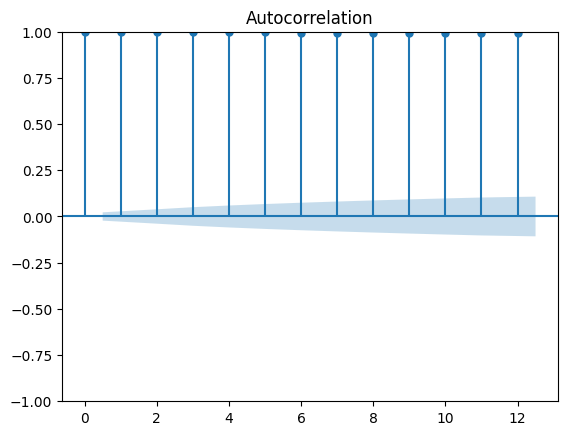

In [13]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Ex_rate, lags=12)
plt.show()

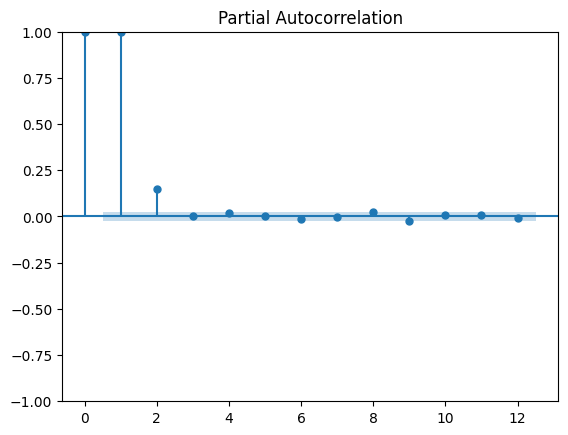

In [16]:
tsa_plots.plot_pacf(data.Ex_rate, lags=12)
plt.show()

In [21]:
##Step-2: Model fitting
from statsmodels.tsa.arima.model import ARIMA
#Define the model
p,d,q = 1,1,1
arima_model = ARIMA(data["Ex_rate"], order=(p,d,q))

#fit the model
arima_result = arima_model.fit()

#summary of model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 24 Jan 2025   AIC                         -56102.322
Time:                        09:42:18   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

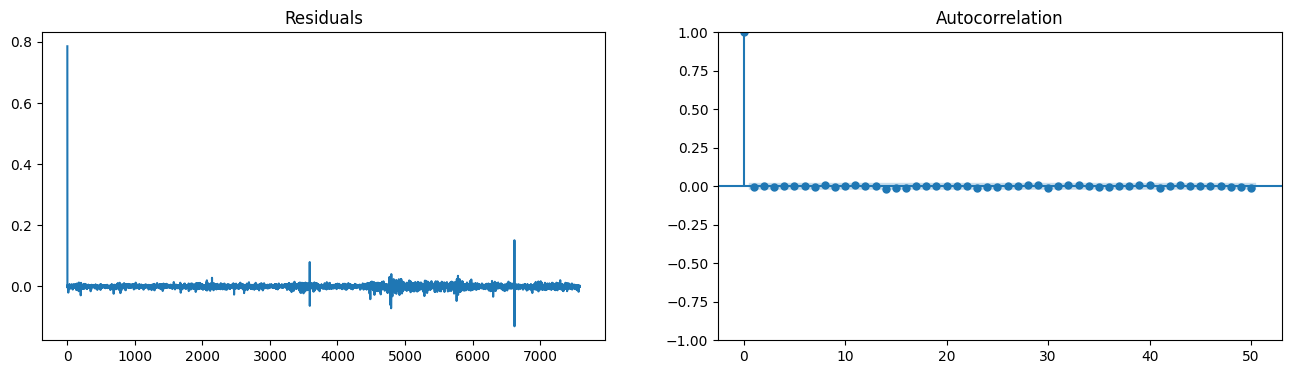

In [23]:
# Step 3: Diagnostics
# Residual diagnostics
residuals = arima_result.resid
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(residuals)
axes[0].set_title('Residuals')
plot_acf(residuals, lags=50, ax=axes[1])
plt.show()

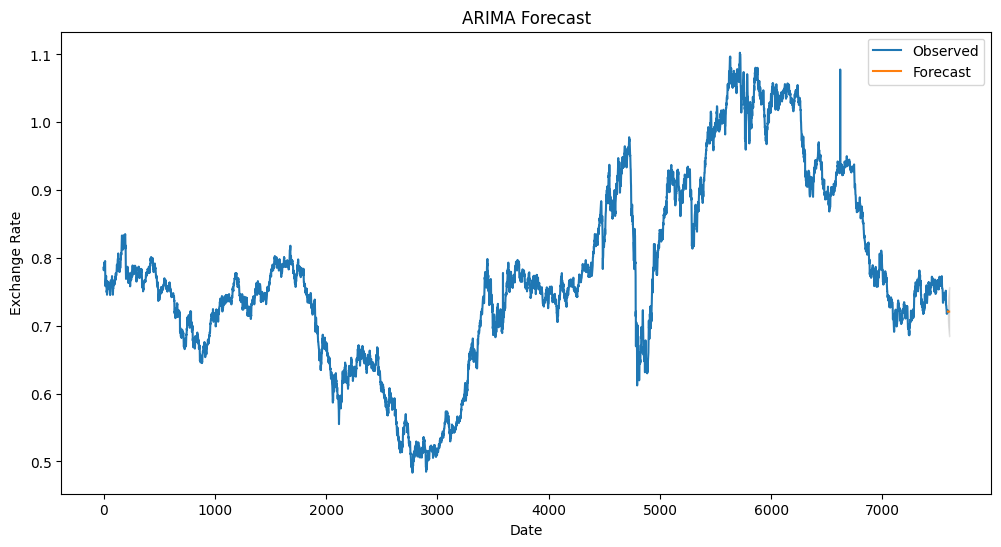

In [24]:
# Step 4: Forecasting
# Forecasting
forecast_steps = 12  # Number of steps to forecast
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Part 3: Model Building - Exponential Smoothing

In [25]:
# Step 1: Model Selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the model (Holt-Winters Exponential Smoothing)
exp_model = ExponentialSmoothing(data['Ex_rate'], seasonal='add', seasonal_periods=12)

# Fit the model
exp_result = exp_model.fit()

# Summary of the model
print(exp_result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.479
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Fri, 24 Jan 2025
Box-Cox:                          False   Time:                         09:43:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698370                alpha                 True
smoothing_seasonal       

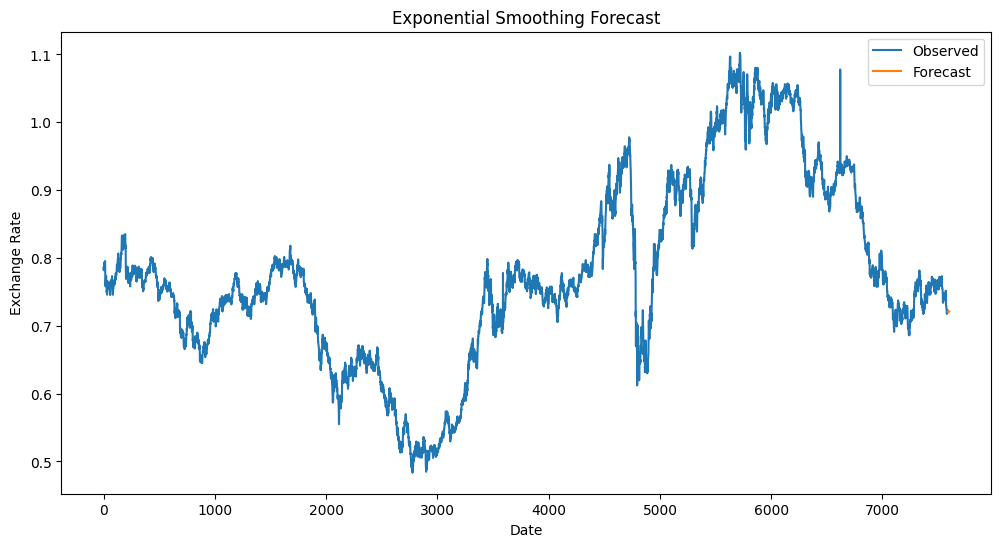

In [26]:
# Forecasting
exp_forecast = exp_result.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Observed')
plt.plot(exp_forecast, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


### Part 4: Evaluation and Comparison

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute error metrics for ARIMA
arima_forecast_values = forecast.predicted_mean
arima_mae = mean_absolute_error(data['Ex_rate'][-forecast_steps:], arima_forecast_values)
arima_rmse = np.sqrt(mean_squared_error(data['Ex_rate'][-forecast_steps:], arima_forecast_values))
arima_mape = np.mean(np.abs((data['Ex_rate'][-forecast_steps:] - arima_forecast_values) / data['Ex_rate'][-forecast_steps:])) * 100

# Compute error metrics for Exponential Smoothing
exp_forecast_values = exp_forecast
exp_mae = mean_absolute_error(data['Ex_rate'][-forecast_steps:], exp_forecast_values)
exp_rmse = np.sqrt(mean_squared_error(data['Ex_rate'][-forecast_steps:], exp_forecast_values))
exp_mape = np.mean(np.abs((data['Ex_rate'][-forecast_steps:] - exp_forecast_values) / data['Ex_rate'][-forecast_steps:])) * 100

print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}%")
print(f"Exponential Smoothing MAE: {exp_mae}, RMSE: {exp_rmse}, MAPE: {exp_mape}%")


ARIMA MAE: 0.001664492434046964, RMSE: 0.002000358073456273, MAPE: nan%
Exponential Smoothing MAE: 0.001578197655860536, RMSE: 0.0018717520708353703, MAPE: nan%


In [28]:
# Based on error metrics, we can see which model performs better

if arima_mae < exp_mae:
    print("ARIMA model performs better in terms of MAE.")
else:
    print("Exponential Smoothing model performs better in terms of MAE.")

if arima_rmse < exp_rmse:
    print("ARIMA model performs better in terms of RMSE.")
else:
    print("Exponential Smoothing model performs better in terms of RMSE.")

if arima_mape < exp_mape:
    print("ARIMA model performs better in terms of MAPE.")
else:
    print("Exponential Smoothing model performs better in terms of MAPE.")


Exponential Smoothing model performs better in terms of MAE.
Exponential Smoothing model performs better in terms of RMSE.
Exponential Smoothing model performs better in terms of MAPE.
